In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import numpy as np
import seaborn as sea

In [11]:
# ds=xr.open_dataset('4901476_prof.nc')
# ds=xr.open_dataset('4901477_prof.nc')
ds=xr.open_dataset('4902916_prof.nc')
ds


<xarray.Dataset>
Dimensions:                       (N_PROF: 419, N_PARAM: 3, N_LEVELS: 1024,
                                   N_CALIB: 1)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/52)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COMMENT      (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_DATE         (N_PROF, N_CALIB, N_PARAM) object ...
Attributes:
    title:                Argo float aggregated multi-cycle profile
    institution:          US GDAC
    source:               Argo float
    history:              2023-03-05T00:00:55Z
    references:           http://www.argodatamgt.org/Documentation
    comment:              free text
    user_manual_version:  3.2
    Conventions:          Argo-3.2 CF-1.6
    featureType:          trajectoryProfile

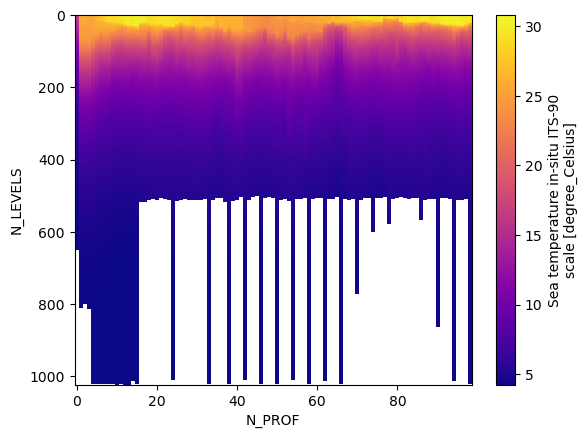

In [3]:
ds.TEMP_ADJUSTED[1:100].T.plot(cmap=plt.cm.plasma)
plt.gca().invert_yaxis()

In [ ]:
''' Obtuve las fechas de los respectivos perfiles'''
# import pandas as pd
# import numpy as np 
# Fechas=pd.DataFrame(np.array(ds.JULD[42:55].dt.strftime('%y/%m/%d').data) , 
#              np.array(ds.JULD[23:36].dt.strftime('%y/%m/%d').data))
# Fechas
# # Fechas.to_csv('C:/Users/Atmosfera/Pictures/ARGO/Estaciones.csv')

#### Energia Potencial de Boyancia

In [12]:
################################# Diferencias Finitas
def Dif (a,x):
    ai =a[:-2]
    bi =a[2:]
    h = bi-ai
    Dcen= (x[2:]-x[:-2])/(h)
    return (Dcen)

################################ Regla del Trapecio
def integratrapecio_fi(xi,fi):
    n = len(xi)
    trapecios = np.zeros_like(xi)
    dx = xi[1:]-xi[:-1]
    trapecios = dx*(fi[1:]+fi[:-1])/2
    return(trapecios)
#################################  Arreglo de zeros
PP= np.zeros(shape=(1020,350))
Depth=np.zeros(shape=(1024,350))
DPot=np.zeros(shape=(1024,350))
BV=np.zeros(shape=(1023,350))
for i in range(350):     ### Ciclo
    lon = ds.LONGITUDE[i]
    lat = ds.LATITUDE[i]
    T = ds.TEMP_ADJUSTED[i]   # in situ T
    P = ds.PRES_ADJUSTED[i]   # presión
    Sp = ds.PSAL_ADJUSTED[i]  #salinidad práctica
    SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
    Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
    CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
    ########################
    Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000
    N2,p_mid=gsw.Nsquared(SA,CT,P)
    z = -1*gsw.z_from_p(P,lat) # Depht real  a través de la Presion y Lat del perfil
    d = np.array(Dens)
    ###########3###########
    DC = Dif(z,d)
   #############################3
    at = integratrapecio_fi(z[1:-1],DC) # arreglo con las áreas de los trapecios
    ic= np.cumsum(at) # suma cumulativa de áreas de los trapecios
    ############################
    f1 = ic
    a_t = integratrapecio_fi(z[2:-1],f1) # arreglo con las áreas de los trapecios
    i_c = np.cumsum(a_t) # suma cumulativa de áreas de los trapecios #EPB
    #######################33#
    i_c=i_c
    PP[:,i]=i_c
    Depth[:,i]=z
    DPot[:,i]=Dens
    BV[:,i]=N2

In [ ]:
#Graficamos
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(1,4,figsize=(7,4.5),sharey=True)
    fig.suptitle(' Energía Potencial de Boyancia', fontsize =11,color ='k',y=0.93) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    # fig.supxlabel(r'Energía ($J/m^3$)',fontsize=10,y=-0.03)
    fig.supylabel('Profundidad (m)',fontsize=10,x=-0.02)
    # fig.subplots_adjust(hspace=0)

    axs[0].plot(PP[:,10],Depth[0:-4,10],'k',linewidth = 1.6,label=ds.JULD[10].dt.strftime('%y/%m/%d').values)
    axs[0].plot([-50,400],[Depth[16,10],Depth[16,10]],'r--',label='MLD',linewidth=1.5)
    axs[0].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[0].legend(fontsize=6)
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    axs[0].set_ylim(180,-5)
    axs[0].set_xlim(-55,400)
    
    axs[1].plot(PP[:,15],Depth[0:-4,15],'k',linewidth = 1.6,label=ds.JULD[20].dt.strftime('%y/%m/%d').values)
    axs[1].plot([-50,400],[Depth[23,15],Depth[23,15]],'r--',label='MLD',linewidth=1.5)
    axs[1].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[1].legend(fontsize=6)
    axs[1].invert_yaxis()
    axs[1].grid(linestyle='--',linewidth=0.7)
    axs[1].set_ylim(180,-5)
    axs[1].set_xlim(-55,400)
    
#     axs[2].plot(PP[:,100],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[100].dt.strftime('%y/%m/%d').values)
#     axs[2].plot([-50,400],[z[45],z[45]],'r--',label='MLD',linewidth=1.5)
#     axs[2].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
#     axs[2].legend(fontsize=6)
#     axs[2].invert_yaxis()
#     axs[2].set_ylim(180,-5)
#     axs[2].set_xlim(-55,400)
#     axs[2].grid(linestyle='--',linewidth=0.7)
    
#     axs[3].plot(PP[:,105],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[105].dt.strftime('%y/%m/%d').values)
#     axs[3].plot([-50,400],[z[58],z[58]],'r--',label='MLD',linewidth=1.5)
#     axs[3].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
#     axs[3].legend(fontsize=6)
#     axs[3].invert_yaxis()
#     axs[3].set_ylim(180,-5)
#     axs[3].set_xlim(-55,400)
#     axs[3].grid(linestyle='--',linewidth=0.7)

#### format(np.mean(PP[:,1]),'.2f')

In [16]:
ds.JULD[291].data

numpy.datetime64('2021-06-05T23:02:39.002470656')

In [21]:
PP[0:10,291] 

array([ 1.83308691,  4.69631888,  8.04651242, 11.65774983, 15.27546878,
       19.20653456, 24.46344435, 31.95175504, 40.45926974, 49.42241322])

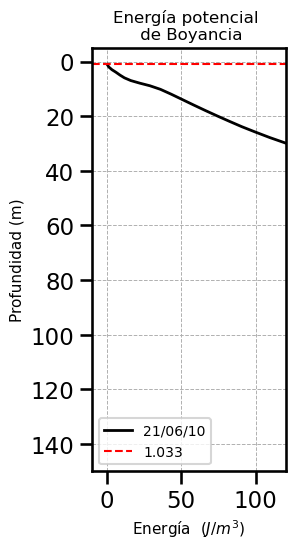

In [55]:
n= 0
nprof=292
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(2.5,5.5))
    ax.plot(PP[:,nprof],Depth[0:-4,nprof],'k',linewidth = 2,label=ds.JULD[nprof].dt.strftime('%y/%m/%d').values)
    ax.set_ylabel( 'Profundidad (m)',fontsize=11)
    ax.set_xlabel(r'Energía  ($J/m^3$)',fontsize=11)
    ax.set_title('Energía potencial \n de Boyancia', fontsize =12,color = 'black')
    
    ax.plot([-10,400],[Depth[n,nprof],Depth[n,nprof]],'r--',label=format(Depth[n,nprof],'.3f'),linewidth=1.5)
    # ax.plot([-10,400],[Depth[14,nprof],Depth[14,nprof]],'b--',label=format(Depth[14,nprof],'.2f'),linewidth=1.5)
    # ax.plot([-10,400],[z[11],z[11]],'r--',label=format(z[11],'.2f'),linewidth=1.5)
    # ax.legend(fontsize=8)
    ax.set_ylim(-5,150)
    ax.set_xlim(-10,120)
    ax.invert_yaxis()
    ax.grid(linestyle='--',linewidth=0.7)
    ax.legend(fontsize=10)

In [ ]:
PP.shape, Depth.shape , DPot.shape

In [ ]:
num=80
fig, ax1 = plt.subplots(figsize=(2,5))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'EPB($J/m^3$)', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(PP[:,num],Depth[0:-4,num] ,'k', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='k')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel(r'Densidad ($\rho$)',color='blue',fontsize=10)  # we already handled the x-label with ax1
ax2.plot(DPot[:,num],Depth[:,num],'blue',linewidth = 2.1)
ax2.tick_params(axis='x', labelcolor='b',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

In [ ]:
num=80
fig, ax1 = plt.subplots(figsize=(2,5))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'EPB($J/m^3$)', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(PP[:,num],Depth[0:-4,num] ,'k', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='k')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel('Frecuencia de \n Brunt-Väisälä (Hz)',color='red',fontsize=9)  # we already handled the x-label with ax1
ax2.plot(BV[:,num],Depth[0:-1,num],'red',linewidth = 2.1)
ax2.tick_params(axis='x', labelcolor='r',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

In [ ]:
num=80
fig, ax1 = plt.subplots(figsize=(2,5))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'Densidad ($\rho$)',color='blue', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(DPot[:,num],Depth[:,num] ,'b', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='b')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel('Frecuencia de \n Brunt-Väisälä (Hz)',color='red',fontsize=9)  # we already handled the x-label with ax1
ax2.plot(BV[:,num],Depth[0:-1,num],'red',linewidth = 2.5)
ax2.tick_params(axis='x', labelcolor='r',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
# ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
with sea.plotting_context('talk'):
    fig =plt.figure(figsize=(2.9,4))
    fig.tight_layout()
    # fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=12, y=1.02 )

    # gs = gridspec.GridSpec(3, 3,EPB vs $N^2$
    #                       wspace=0.5, hspace=0.05)
    gs = fig.add_gridspec(2, 2,wspace=0.5, hspace=0.4)
    ax=fig.add_subplot(gs[:, 0])
    color = 'tab:red'
    ax.set_xlabel(' Brunt-Vaisala\n Frecuency (Hz)', color=color, fontsize=11)
    ax.set_ylabel('Profundidad (m)',fontsize=12)
    ax.plot(BV[:,num],Depth[0:-1,num],'red',linewidth = 1.5)
    ax.tick_params(axis='x' ,labelcolor=color)
    ax.autoscale(True)

    ax = ax.twiny()  # instantiate a second axes that shares the same x-axis
    color = 'black'
    ax.set_xlabel(r'Density ($\rho$)', color=color, fontsize=11)  # we already handled the x-label with ax1
    ax.plot(PP[:,num],Depth[0:-4,num] ,'k', linewidth = 1.5)
    ax.tick_params(axis='x', labelcolor=color,)
    ax.invert_yaxis()

     # otherwise the right y-label is slightly clipped
    ax.grid(linestyle='--', linewidth=0.6)
    # ax.set_ylim(800,-5)
    
# ax1 = fig.add_subplot(gs[1:2, 1])
# color1 = 'tab:red'
# ax1.plot(N2,p_mid ,color=color1, linewidth = 1.5) # label = ds3.JULD[2].dt.strftime('%y/ %m/ %d').values)
# ax1.invert_yaxis()
# ax1.set_ylim(750,-5)
# ax1.set_xlabel(' Brunt-Vaisala\n Frecuency (Hz)', color=color1, fontsize=9)
# # ax1=fig.tight_layout()
# # ax1.set_xlim(22.3,25)
# # ax1.get_xaxis().set_visible(False)
# ax1.grid(linestyle='--',linewidth=0.7)

# ax2= fig.add_subplot(gs[0:1, 1])
# color2 = 'black'
# ax2.plot(Dens,depth,color=color2,linewidth = 2.1)#, label = ds3.JULD[11].dt.strftime('%y/ %m/ %d').values)
# ax2.set_xlabel(r'Density ($\rho$)', color=color2, fontsize=9)
# ax2.invert_yaxis()
# ax2.set_ylim(750,-5)
# ax2.set_xlim(23.7,26.3)
# # ax2.get_yaxis().set_visible(False)
# ax2.grid(linestyle='--',linewidth=0.7)

In [ ]:
#Graficamos el perfil EPB
nprof=80
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(2.5,5.8))
    ax.plot(PP[:,nprof],Depth[0:-4,nprof],'k',linewidth = 2,label=ds.JULD[nprof].dt.strftime('%y/%m/%d').values)
    ax.set_ylabel( 'Profundidad (m)',fontsize=11)
    ax.set_xlabel(r'Energía  ($J/m^3$)',fontsize=11)
    ax.set_title('Energía potencial de Boyancia', fontsize =12,color = 'black')
    
    ax.plot([-10,400],[Depth[19,nprof],Depth[19,nprof]],'r--',label=format(Depth[19,nprof],'.2f'),linewidth=1.5)
    ax.plot([-10,400],[Depth[14,nprof],Depth[14,nprof]],'b--',label=format(Depth[14,nprof],'.2f'),linewidth=1.5)
    # ax.plot([-10,400],[z[11],z[11]],'r--',label=format(z[11],'.2f'),linewidth=1.5)
    ax.legend(fontsize=8)
    ax.invert_yaxis()
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.annotate('----',xy=(PP[25,54],z[25]))
    ax.set_ylim(150,-5)
    # ax.set_xlim(-10,250)
# plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/Boyancia.png')

In [57]:
# ds

#### Obteniendo los perfiles de densidad

In [58]:
DP= np.zeros(shape=(1024,350))
for i in range(350):     ### Ciclo
    lon = ds.LONGITUDE[i]
    lat = ds.LATITUDE[i]
    T = ds.TEMP_ADJUSTED[i]   # in situ T
    P = ds.PRES_ADJUSTED[i]   # presión
    Sp = ds.PSAL_ADJUSTED[i]  #salinidad práctica
    SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
    Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
    CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
    ########################
    Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000
    DP[:,i]=Dens

In [ ]:
# #Graficamos
# with sea.plotting_context('talk'):
#     fig, ax = plt.subplots(figsize=(3,5))
#     ax.plot(DP[:,2],z,'blue',linewidth = 2.5)
    
#     ax.set_ylabel( 'Profundidad (m)')
#     ax.set_xlabel(r'$Densidad(kg/m^3)$')
#     ax.set_title(r'Perfil vertical de Densidad $(\rho)$',fontsize =16)
    
#     ax.legend()
#     ax.invert_yaxis()
#     ax.set_ylim(120,-5)
#     ax.set_xlim(24,26)
#     #     ax.invert_xaxis()
#     ax.grid()

In [59]:
PP.shape

(1020, 350)

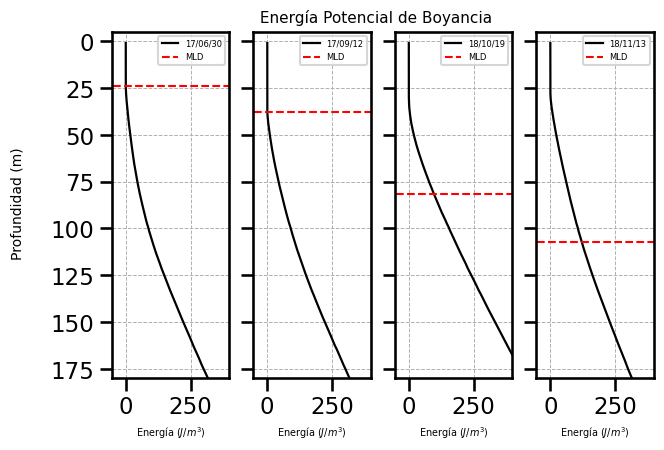

In [60]:
#Graficamos
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(1,4,figsize=(7,4.5),sharey=True)
    fig.suptitle(' Energía Potencial de Boyancia', fontsize =11,color ='k',y=0.93) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    # fig.supxlabel(r'Energía ($J/m^3$)',fontsize=10,y=-0.03)
    fig.supylabel('Profundidad (m)',fontsize=10,x=-0.02)
    # fig.subplots_adjust(hspace=0)

    axs[0].plot(PP[:,10],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[10].dt.strftime('%y/%m/%d').values)
    axs[0].plot([-50,400],[z[16],z[16]],'r--',label='MLD',linewidth=1.5)
    axs[0].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[0].legend(fontsize=6)
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    axs[0].set_ylim(180,-5)
    axs[0].set_xlim(-55,400)
    
    axs[1].plot(PP[:,20],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[20].dt.strftime('%y/%m/%d').values)
    axs[1].plot([-50,400],[z[23],z[23]],'r--',label='MLD',linewidth=1.5)
    axs[1].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[1].legend(fontsize=6)
    axs[1].invert_yaxis()
    axs[1].grid(linestyle='--',linewidth=0.7)
    axs[1].set_ylim(180,-5)
    axs[1].set_xlim(-55,400)
    
    axs[2].plot(PP[:,100],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[100].dt.strftime('%y/%m/%d').values)
    axs[2].plot([-50,400],[z[45],z[45]],'r--',label='MLD',linewidth=1.5)
    axs[2].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[2].legend(fontsize=6)
    axs[2].invert_yaxis()
    axs[2].set_ylim(180,-5)
    axs[2].set_xlim(-55,400)
    axs[2].grid(linestyle='--',linewidth=0.7)
    
    axs[3].plot(PP[:,105],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[105].dt.strftime('%y/%m/%d').values)
    axs[3].plot([-50,400],[z[58],z[58]],'r--',label='MLD',linewidth=1.5)
    axs[3].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[3].legend(fontsize=6)
    axs[3].invert_yaxis()
    axs[3].set_ylim(180,-5)
    axs[3].set_xlim(-55,400)
    axs[3].grid(linestyle='--',linewidth=0.7)
# plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/Comparacion.png')

In [36]:
time=10
lon = ds.LONGITUDE[time]
lat = ds.LATITUDE[time]
T = ds.TEMP_ADJUSTED[time]   # in situ T
P = ds.PRES_ADJUSTED[time]   # presión
Sp = ds.PSAL_ADJUSTED[time]  #salinidad práctica
SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
########################
Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000

N2,p_mid=gsw.Nsquared(SA,CT,P)

In [37]:
ds.JULD_LOCATION[60:80].data

array(['2018-03-31T23:16:00.002490880', '2018-04-05T22:25:00.002396672',
       '2018-04-10T21:32:00.002299648', '2018-04-16T01:38:00.000162560',
       '2018-04-21T01:07:00.000117504', '2018-04-26T00:14:00.000020224',
       '2018-04-30T23:22:00.002499584', '2018-05-06T03:39:00.000378624',
       '2018-05-11T03:05:00.000329216', '2018-05-16T02:16:00.000237824',
       '2018-05-21T01:28:00.000147968', '2018-05-26T07:50:00.000823552',
       '2018-05-31T07:15:00.000772864', '2018-06-05T06:24:00.000678656',
       '2018-06-10T05:37:00.000590080', '2018-06-15T11:11:00.001196032',
       '2018-06-20T10:28:00.001113600', '2018-06-25T09:39:00.001022208',
       '2018-06-30T08:54:00.000936704', '2018-07-05T14:35:00.001552896'],
      dtype='datetime64[ns]')

In [75]:
DP[0:10,291]

array([18.18282037, 18.83333281, 20.04018895, 21.29425233, 22.24436276,
       22.42508359, 22.58643776, 22.72818546, 22.91088012, 23.14280798])

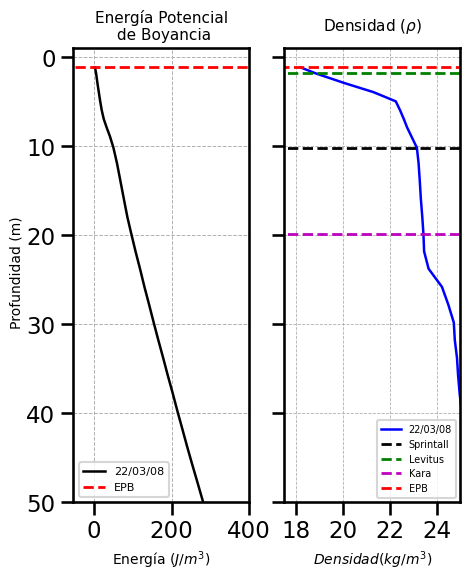

In [96]:
#Graficamos
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(1,2,figsize=(5,5.9),sharey=True)
    # fig.suptitle('Comparativa entre perfiles ', fontsize=14) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    fig.supylabel('Profundidad (m)',fontsize=10,x=-0.001)
    # fig.subplots_adjust(hspace=0)

    axs[0].plot(PP[:,291],Depth[0:-4,291],'k',linewidth = 1.8,label=ds.JULD[i].dt.strftime('%y/%m/%d').values)
    axs[0].set_xlabel(r'Energía ($J/m^3$)',fontsize=10)
    axs[0].set_title('Energía Potencial\n de Boyancia', fontsize =11,color = 'black')

    # axs[0].plot(PP[35,23],z[35],'r.', label='MLD',markersize=11)
    axs[0].plot([-50,400],[Depth[0,291],Depth[0,291]],'r--',label='EPB',linewidth=2)
    axs[0].legend(fontsize=8, loc='lower left')
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    # axs[0].set_ylim(90,-5)
    axs[0].set_xlim(-55,400)

    axs[1].plot(DP[:,291],Depth[:,291],'blue',linewidth = 1.8,label=ds.JULD[i].dt.strftime('%y/%m/%d').values)
    axs[1].set_xlabel(r'$Densidad(kg/m^3)$',fontsize=10)
    axs[1].set_title(r'Densidad $(\rho)$',fontsize =11,y=1.02)
    # axs[1].plot(DP[31,23],z[31],'k.', label='Sprintall')
    # axs[1].plot(DP[35,23],z[35],'g.', label='Levitus')
    # axs[1].plot(DP[33,23],z[33],'r.', label='Kara')
    axs[1].plot([12,27],[Depth[9,291],Depth[9,291]],'k--', label='Sprintall',linewidth=2)
    axs[1].plot([12,27],[Depth[1,291],Depth[1,291]],'g--', label='Levitus',linewidth=2)
    axs[1].plot([12,27],[Depth[14,291],Depth[14,291]],'m--', label='Kara',linewidth=2)
    # axs[1].plot([12,27],[Depth[3,291],Depth[3, 291]],'y--', label='HYCOM',linewidth=2.5)
    axs[1].plot([-50,400],[Depth[0,291],Depth[0,291]],'r--',label='EPB',linewidth=2)
    axs[1].legend( loc = 'lower right' , fontsize=7)
    # axs[1].invert_yaxis()
    axs[1].set_ylim(50,-1)
    axs[1].set_xlim(17.5,25)
    #     ax.invert_xaxis()
    axs[1].grid(linestyle='--',linewidth=0.6)
plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/inversion.png')

In [ ]:
# fig, ax1 = plt.subplots(figsize=(2,5))
# fig.tight_layout()  
# # fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

# ax1.set_xlabel(' Brunt-Vaisala\n Frecuency (Hz)', fontsize=10)
# ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
# ax1.plot(N2,p_mid ,'k', linewidth = 1.5)
# ax1.tick_params(axis='x' ,labelcolor='k')
# ax1.autoscale(True)

# ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

# ax2.set_xlabel(r'Density ($\rho$)',color='red',fontsize=10)  # we already handled the x-label with ax1
# ax2.plot(PP[:,23],z[0:-4],'red',linewidth = 2.1)
# ax2.tick_params(axis='x', labelcolor='r',)
# ax2.invert_yaxis()

# ax1.grid(linestyle='--', linewidth=0.6)
# ax1.set_ylim(280,-5)

# # ax1.set_xlim(23.8,26)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# fig = plt.figure()
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")

# gs = GridSpec(4, 2)#, height_ratios=[2, 1])
# ax = fig.add_subplot(gs[0])
# ax = fig.add_subplot(gs[1])
# ax = fig.add_subplot(gs[2])
# ax = fig.add_subplot(gs[3])
# ax = fig.add_subplot(gs[4])
# ax = fig.add_subplot(gs[5])
# ax = fig.add_subplot(gs[6])
# ax = fig.add_subplot(gs[7])
# # ax4 = fig.add_subplot(gs[3])

# # annotate_axes(fig)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(4,5),canvas=True)
# gs = gridspec.GridSpec(3, 3)

# ax1=fig.add_subplot(gs[0:1, :1])
# ax1.plot(PP[:,4],z[0:-4],'k',linewidth = 2)
# ax1.set_ylabel( 'Profundidad (m)',fontsize=11)
# ax1.set_xlabel(r'Energía ($J/m^3$)',fontsize=11)

# ax1.plot(PP[27,54],z[27],color='k', label='MLD')
# ax1.legend(fontsize=9)
# ax1.invert_yaxis()
# ax1.grid(linestyle='--',linewidth=0.7)
# # ax.annotate('----',xy=(PP[25,54],z[25]))
# ax1.set_ylim(250,-5)
# # ax1.set_xlim(-25,350)
# ax2 = fig.add_subplot(gs[1:2, 0])
# ax3 = fig.add_subplot(gs[0:1, 2])
# ax4 = fig.add_subplot(gs[1:2, 2])
# # ax4 = fig.add_subplot(gs[2:3, 2])

# plt.suptitle("GridSpec Inside GridSpec")
# # format_axes(fig)

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(4,5),canvas=True)
# gs = gridspec.GridSpec(1, 3)
# ax1=fig.add_subplot(gs[0, 0])
# ax1=fig.add_subplot(gs[0, 1])
# ax1=fig.add_subplot(gs[0, 2])


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# fig = plt.figure()
# gs = gridspec.GridSpec(3, 3)
# ax1=fig.add_subplot(gs[0, 0])
# ax2=fig.add_subplot(gs[1, 0])
# ax3==fig.add_subplot(gs[2, 0])
# ax4=fig.add_subplot(gs[:, 1])
# ax5=fig.add_subplot(gs[0, 2])
# ax6=fig.add_subplot(gs[1, 2])
# ax7=fig.add_subplot(gs[2, 2])

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(4, 4), layout="constrained", sharey=True, sharex=True)

In [ ]:
# conda list 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import numpy as np
import seaborn as sea

In [ ]:
import tropycal.tracks as tracks
basin = tracks.TrackDataset(basin='north_atlantic')

In [ ]:
storm = basin.get_storm(('michael',2018))

In [ ]:
storm.to_dict()
storm.to_xarray()
storm.to_dataframe()

In [ ]:
# storm.plot(size=1)

#### Graficas por temporada 

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import numpy as np
import seaborn as sea
import pandas as pd 

In [ ]:
# data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')
data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD_V.csv')
type(data), data

In [ ]:
# print (type(n_data.MT[0]))

In [ ]:
data['MT'] = pd.to_datetime(data['MT'])
print (type(data.MT[0]))

In [ ]:
datos = data.sort_values(by='MT')
datos

In [ ]:
# datos['MT'][0:12], datos['MT'][12:25], datos['MT'][25:]

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,4))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)
    # fig.supxlabel('Tiempo ',fontsize=12)

    ax.plot(datos['MT'], datos['LEVITUS']-datos['PE'],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
    ax.plot(datos['MT'], datos['SPRINTALL']-datos['PE'],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
    ax.plot(datos['MT'], datos['KARA']-datos['PE'],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    ax.plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')
    # ax.set_ylim(-2,70)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9, loc = 'lower left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    plt.suptitle('Diferencias entre metodologías y EPB \n en verano',fontsize =11,y=0.99,fontweight ='bold')
# plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/Dif_verano.png')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)
    # fig.supxlabel('Tiempo ',fontsize=12)

    ax.plot(datos['MT'][0:12], datos['LEVITUS'][0:12]-datos['PE'][0:12],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][0:12], datos['SPRINTALL'][0:12]-datos['PE'][0:12],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][0:12], datos['KARA'][0:12]-datos['PE'][0:12],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-15,45)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9, loc = 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2014',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 12,25 
    ax.plot(datos['MT'][ini:fin], datos['LEVITUS'][ini:fin]-datos['PE'][ini:fin],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][ini:fin], datos['SPRINTALL'][ini:fin]-datos['PE'][ini:fin],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][ini:fin], datos['KARA'][ini:fin]-datos['PE'][ini:fin],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][ini:fin], datos['HYCOM_1'][ini:fin],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-45,15)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2019',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 25,78 
    ax.plot(datos['MT'][ini:fin], datos['LEVITUS'][ini:fin]-datos['PE'][ini:fin],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][ini:fin], datos['SPRINTALL'][ini:fin]-datos['PE'][ini:fin],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][ini:fin], datos['KARA'][ini:fin]-datos['PE'][ini:fin],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][ini:fin], datos['HYCOM_1'][ini:fin],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-65,45)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2021',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
# data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')
data_i=pd.read_csv('C:/Users/Atmosfera/Videos/MLD_I.csv')
type(data_i), data_i

In [ ]:
data_i['mt'] = pd.to_datetime(data_i['mt'])
print (type(data_i.mt[0]))

In [ ]:
base = data_i.sort_values(by='mt')
base

In [ ]:
# base['mt'][0:13], base['mt'][13:25], base['mt'][26:]

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,4))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)
    # fig.supxlabel('Tiempo ',fontsize=12)

    ax.plot(base['mt'], base['Levitus']-base['epb'],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    ax.plot(base['mt'], base['Sprintall']-base['epb'],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    ax.plot(base['mt'], base['Kara']-base['epb'],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    ax.plot(base['mt'][0:12], base['Hycom_i'][0:12],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    ax.set_ylim(-130,130)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8, loc = 'upper center')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    plt.suptitle('Diferencias entre metodologías y EPB \n en invierno',fontsize =11,y=0.99,fontweight ='bold')
plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/Dif_invierno.png')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 0,13 
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    ax.set_ylim(-95,140)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8, loc = 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2013/2014',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 13,25 
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    ax.set_ylim(-75,75)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8, loc= 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2019/2020',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 26,78
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    # ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    # ax.set_ylim(-2,70)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2013/2014',fontsize =11,y=0.989,fontweight ='bold')

In [ ]:
with sea.plotting_context():
    fig,axs = plt.subplots(2,1,figsize=(5,5.5))#,sharey=True)
    fig.suptitle('Diferencias entre valores de MLD \n por año', fontsize=10,fontweight='bold', y=0.95) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=11, x=-0.0001)
    # fig.subplots_adjust(vspace=5)
    axs[0].plot(datos['MT'], datos['LEVITUS']-datos['PE'],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
    axs[0].plot(datos['MT'], datos['SPRINTALL']-datos['PE'],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
    axs[0].plot(datos['MT'], datos['KARA']-datos['PE'],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    axs[0].plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')
    axs[0].legend(ncol=4,fontsize=7, loc = 'lower left')
    axs[0].grid(linestyle='--',linewidth=0.7)

    
    axs[1].plot(base['mt'], base['Levitus']-base['epb'],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    axs[1].plot(base['mt'], base['Sprintall']-base['epb'],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    axs[1].plot(base['mt'], base['Kara']-base['epb'],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    axs[1].plot(base['mt'][0:12], base['Hycom_i'][0:12],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    
    axs[1].set_ylim(-130,130)
    axs[1].legend(ncol=4,fontsize=7, loc = 'lower left')
    axs[1].grid(linestyle='--',linewidth=0.7)
plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/MLD_epb.png')

In [ ]:
# with sea.plotting_context('talk'):
#     fig, ax = plt.subplots(figsize=(5,4.5))
#     fig.supylabel('Profundidad (m)',fontsize=12,x=-0.01)

#     ax.plot(data['LEVITUS'][0:16],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
# #     # ax.plot(data['LEVITUS'][16:31],'o',mfc='yellowgreen',mec='red',markerize=6)

#     ax.plot(data['SPRINTALL'][0:16],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
# # #     # ax.plot(data['SPRINTALL'][16:31],'o',mfc='white',mec='red',markersize=6)

#     ax.plot(data['KARA'][0:16],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
# #     # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
#     ax.plot(data['EPB'][0:16],'o',mfc='tomato',mec='red',markersize=6,label='EPB')
# #     # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
#     ax.plot(data['HYCOM'][0:16],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')
#     # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)

#     # plt.plot(data[:][0:16],'.')
#     ax.plot([3.5,3.5],[0,70],'k--',linewidth=1.5)
#     ax.plot([7.5,7.5],[0,70],'k--',linewidth=1.5)
#     ax.plot([11.5,11.5],[0,70],'k--',linewidth=1.5)
#     # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
#     plt.text(1,1.5,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     plt.text(4.8,1.5,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     plt.text(9,1.5,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     plt.text(12.8,1.5,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
#     ax.set_ylim(-2,70)
#     ax.invert_yaxis()
#     ax.legend(ncol=3,fontsize=8.5)
#     ax.grid(linestyle='--',linewidth=0.7)
#     ax.get_xaxis().set_visible(False)
    
#     plt.suptitle('Promedios mensuales por metodología \n en verano',fontsize =10,y=0.955,fontweight ='bold')

In [ ]:
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(5,4.5))
    fig.supylabel('Profundidad (m)',fontsize=12,x=-0.01)

    ax.plot(data['LEVITUS'][16:32],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    # ax.plot(data['LEVITUS'][16:31],'o',mfc='yellowgreen',mec='red',markersize=6)

    ax.plot(data['SPRINTALL'][16:32],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    # ax.plot(data['SPRINTALL'][16:31],'o',mfc='white',mec='red',markersize=6)

    ax.plot(data['KARA'][16:32],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['EPB'][16:32],'o',mfc='tomato',mec='blue',markersize=6,label='EPB')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['HYCOM'][16:32],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)

    # plt.plot(data[:][0:16],'.')
    ax.plot([19.5,19.5],[0,130],'k--',linewidth=1.5)
    ax.plot([23.5,23.5],[0,130],'k--',linewidth=1.5)
    ax.plot([27.5,27.5],[0,130],'k--',linewidth=1.5)
    # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
    plt.text(17,1.8,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(21,1.8,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(25,1.8,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(29,1.8,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
    ax.set_ylim(-3,130)
    ax.legend(ncol=3,loc='lower left',fontsize=8.5)
    ax.invert_yaxis()
    ax.grid(linestyle='--',linewidth=0.7)
    ax.get_xaxis().set_visible(False)
    plt.suptitle('Promedios mensuales por metodología \n en invierno',fontsize =10,y=0.955,fontweight ='bold')

In [ ]:
plt.plot(data[:][16:31],'o')
plt.legend()

In [ ]:
# data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')

In [ ]:
# with sea.plotting_context('talk'):
#     fig,axs = plt.subplots(2,1,figsize=(5,5.5))#,sharey=True)
#     fig.suptitle('Promedios mensuales por temporada', fontsize=10,fontweight='bold') #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
#     fig.supylabel('MLD (m)',fontsize=11)
#     # fig.subplots_adjust(vspace=5)
#     axs[0].plot(data['LEVITUS'][0:16],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')

#     axs[0].plot(data['SPRINTALL'][0:16],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')

#     axs[0].plot(data['KARA'][0:16],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    
#     axs[0].plot(data['EPB'][0:16],'o',mfc='tomato',mec='red',markersize=6,label='EPB')
    
#     axs[0].plot(data['HYCOM'][0:16],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')

#     axs[0].plot([3.5,3.5],[0,130],'k--',linewidth=1.5)
#     axs[0].plot([7.5,7.5],[0,130],'k--',linewidth=1.5)
#     axs[0].plot([11.5,11.5],[0,130],'k--',linewidth=1.5)
#     # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
#     axs[0].text(1,1.5,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     axs[0].text(4.8,1.5,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     axs[0].text(8.7,1.5,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     axs[0].text(12.8,1.5,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
#     axs[0].set_ylim(-8,130)
#     axs[0].invert_yaxis()
#     # axs[0].legend(ncol=3,fontsize=7)
#     axs[0].grid(linestyle='--',linewidth=0.7)
#     axs[0].get_xaxis().set_visible(False)
    
#     # axs[0].set_title('Promedios mensuales por metodología \n en verano',fontsize =10,y=0.955,fontweight ='bold')
#     ###
    
#     axs[1].plot(data['LEVITUS'][16:32],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
#     axs[1].plot(data['SPRINTALL'][16:32],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
#     axs[1].plot(data['KARA'][16:32],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
#     axs[1].plot(data['EPB'][16:32],'o',mfc='tomato',mec='blue',markersize=6,label='EPB')
#     axs[1].plot(data['HYCOM'][16:32],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')

#     axs[1].plot([19.5,19.5],[0,130],'k--',linewidth=1.5)
#     axs[1].plot([23.5,23.5],[0,130],'k--',linewidth=1.5)
#     axs[1].plot([27.5,27.5],[0,130],'k--',linewidth=1.5)
#     # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
#     # axs[1].text(17,2.5,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     # axs[1].text(20.5,2.5,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     # axs[1].text(24.3,2.5,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
#     # axs[1].text(28.8,2.5,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
#     axs[1].set_ylim(-8,130)
#     axs[1].legend(ncol=3,loc='lower left',fontsize=7)
#     axs[1].invert_yaxis()
#     axs[1].grid(linestyle='--',linewidth=0.7)#,y=2)
#     axs[1].get_xaxis().set_visible(False)
    # plt.suptitle('Promedios mensuales por metodología \n en invierno',fontsize =10,y=0.955,fontweight ='bold')
